In [23]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Analisis de datos a gran escala/Proyecto'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Analisis de datos a gran escala/Proyecto


In [24]:
%pip install pyspark

In [97]:
import pandas as pd
import numpy as np
import pyspark as spark

In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, to_date

spark = SparkSession.builder.appName("Accidentes").getOrCreate()

# Leer CSV
df = spark.read.csv("US_Accidents_2016-18.csv", header=True)

#Pasamos las columnas Start_time a sólo la fecha para manejarla mejor. End_Time no nos interesa
df = df.withColumn("Date", to_date("Start_Time"))

df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Cond

In [67]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): string (nullable = true)
 |-- Visibility(

In [68]:
print("Cantidad de datos: ", df.count())

Cantidad de datos:  2021537


In [69]:
from pyspark.sql.functions import col, sum

df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
]).show(truncate=False)

+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+----+
|ID |Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical

In [87]:
df_interest = df.select("Date", "City", "State", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition")

In [88]:
df_interest = df_interest.dropna()
print("Cantidad de datos: ", df_interest.count())

Cantidad de datos:  1621127


In [89]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

categorical_cols = ["City", "State", "Weather_Condition"]

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep")
    for col in categorical_cols
]

pipeline = Pipeline(stages=indexers)
model = pipeline.fit(df_interest)
df_interest = model.transform(df_interest)

In [90]:
df_interest.show(5)

+----------+------------+-----+--------------+-----------+------------+--------------+---------------+-----------------+----------+-----------+-----------------------+
|      Date|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Weather_Condition|City_Index|State_Index|Weather_Condition_Index|
+----------+------------+-----+--------------+-----------+------------+--------------+---------------+-----------------+----------+-----------+-----------------------+
|2016-02-08|Williamsburg|   OH|          36.0|      100.0|       29.67|          10.0|            3.5|         Overcast|     885.0|       12.0|                    1.0|
|2016-02-08|      Dayton|   OH|          35.1|       96.0|       29.64|           9.0|            4.6|    Mostly Cloudy|      26.0|       12.0|                    2.0|
|2016-02-08|      Dayton|   OH|          36.0|       89.0|       29.65|           6.0|            3.5|    Mostly Cloudy|      26.0|       12.0|                 

In [91]:
accidents_per_day = df_interest.groupBy("Date").count().withColumnRenamed("count", "Accidents")

df_interest = df_interest.join(accidents_per_day, on="Date", how="left")
df_interest = df_interest.drop("Start_Time")

df_interest.show(5)

+----------+------------+-----+--------------+-----------+------------+--------------+---------------+-----------------+----------+-----------+-----------------------+---------+
|      Date|        City|State|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Weather_Condition|City_Index|State_Index|Weather_Condition_Index|Accidents|
+----------+------------+-----+--------------+-----------+------------+--------------+---------------+-----------------+----------+-----------+-----------------------+---------+
|2016-02-08|Williamsburg|   OH|          36.0|      100.0|       29.67|          10.0|            3.5|         Overcast|     885.0|       12.0|                    1.0|       49|
|2016-02-08|      Dayton|   OH|          35.1|       96.0|       29.64|           9.0|            4.6|    Mostly Cloudy|      26.0|       12.0|                    2.0|       49|
|2016-02-08|      Dayton|   OH|          36.0|       89.0|       29.65|           6.0|            3.5|    Most

In [93]:
from pyspark.sql.functions import avg

df_interest_countrywise = df_interest.groupBy("Date").agg(
    avg("Temperature(F)").alias("Temperature(F)"),
    avg("Humidity(%)").alias("Humidity(%)"),
    avg("Pressure(in)").alias("Pressure(in)"),
    avg("Visibility(mi)").alias("Visibility(mi)"),
    avg("Wind_Speed(mph)").alias("Wind_Speed(mph)"),
    avg("Weather_Condition_Index").alias("Weather_Condition_Index"),
    avg("Accidents").alias("Accidents")
)

df_interest_countrywise = df_interest_countrywise.orderBy("Date")
df_interest_countrywise.show(5)

+----------+------------------+-----------------+------------------+------------------+------------------+-----------------------+---------+
|      Date|    Temperature(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|   Wind_Speed(mph)|Weather_Condition_Index|Accidents|
+----------+------------------+-----------------+------------------+------------------+------------------+-----------------------+---------+
|2016-01-14|              31.0|             69.0|             29.53|              10.0|               3.0|                    9.0|      7.0|
|2016-02-08|35.355102040816305|91.71428571428571| 29.64163265306123|6.7306122448979595|  6.36326530612245|     3.5714285714285716|     49.0|
|2016-02-09|23.532203389830517|87.11864406779661|29.679830508474573| 2.410169491525424|11.461016949152546|      5.728813559322034|     59.0|
|2016-02-10|17.854347826086954|77.17391304347827|  29.9086956521739| 3.823913043478261|13.147826086956524|      5.239130434782608|     46.0|
|2016-02-11|1

In [110]:
df_interest_countrywise.show(20)

+----------+------------------+------------------+------------------+------------------+------------------+-----------------------+---------+
|      Date|    Temperature(F)|       Humidity(%)|      Pressure(in)|    Visibility(mi)|   Wind_Speed(mph)|Weather_Condition_Index|Accidents|
+----------+------------------+------------------+------------------+------------------+------------------+-----------------------+---------+
|2016-01-14|              31.0|              69.0|             29.53|              10.0|               3.0|                    9.0|      7.0|
|2016-02-08|35.355102040816305| 91.71428571428571| 29.64163265306123|6.7306122448979595|  6.36326530612245|     3.5714285714285716|     49.0|
|2016-02-09|23.532203389830517| 87.11864406779661|29.679830508474573| 2.410169491525424|11.461016949152546|      5.728813559322034|     59.0|
|2016-02-10|17.854347826086954| 77.17391304347827|  29.9086956521739| 3.823913043478261|13.147826086956524|      5.239130434782608|     46.0|
|2016-

In [147]:
df_interest_countrywise.coalesce(1).write.csv("df_interest_countrywise.csv", header=True, mode="overwrite")

In [95]:
from pyspark.sql.functions import year

# DataFrame para 2016 y 2017
df_countrywise_16_17 = df_interest_countrywise.filter(year("Date").isin([2016, 2017]))

# DataFrame para 2018
df_countrywise_18 = df_interest_countrywise.filter(year("Date") == 2018)

In [127]:
df_countrywise_16_17.show(5)
print("--------------------------------------")
print("--------------------------------------")
df_countrywise_18.show(5)

+----------+------------------+-----------------+------------------+------------------+------------------+-----------------------+---------+
|      Date|    Temperature(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|   Wind_Speed(mph)|Weather_Condition_Index|Accidents|
+----------+------------------+-----------------+------------------+------------------+------------------+-----------------------+---------+
|2016-01-14|              31.0|             69.0|             29.53|              10.0|               3.0|                    9.0|      7.0|
|2016-02-08|35.355102040816305|91.71428571428571| 29.64163265306123|6.7306122448979595|  6.36326530612245|     3.5714285714285716|     49.0|
|2016-02-09|23.532203389830517|87.11864406779661|29.679830508474573| 2.410169491525424|11.461016949152546|      5.728813559322034|     59.0|
|2016-02-10|17.854347826086954|77.17391304347827|  29.9086956521739| 3.823913043478261|13.147826086956524|      5.239130434782608|     46.0|
|2016-02-11|1

In [98]:
# Creando X_train y Y_train Usando Pandas
df_ordered = df_countrywise_16_17.orderBy("Date")

pdf = df_ordered.toPandas()

# Extraemos las columnas numéricas y el numero de accidentes
cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition_Index", "Accidents"]

dias = 7
X, y = [], []
for i in range(len(pdf) - dias):
    X.append(pdf.loc[i:i+dias-1, cols].values)  # ventana 7 días
    y.append(pdf.loc[i+dias, "Accidents"])      # día 8

X_train, Y_train = np.array(X), np.array(y)

In [117]:
# Creando X_train y Y_train sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition_Index", "Accidents"]

df_ordered = df_countrywise_16_17.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_np = np.array(df_ordered.select(selected_cols).collect())

# Ventana deslizante
X_train = []
Y_train = []
dias = 7

for i in range(len(data_np) - dias):
    X_train.append(data_np[i:i+dias])       # 7 días de features
    Y_train.append(data_np[i+dias, -1])     # accidentes del día siguiente

X_train = np.array(X_train)  # shape: (num_samples, 7, 7)
Y_train = np.array(Y_train)  # shape: (num_samples,)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (683, 7, 7)
Y_train shape: (683,)


In [118]:
print(X_train[0])
print(Y_train[0])

[[31.         69.         29.53       10.          3.          9.
   7.        ]
 [35.35510204 91.71428571 29.64163265  6.73061224  6.36326531  3.57142857
  49.        ]
 [23.53220339 87.11864407 29.67983051  2.41016949 11.46101695  5.72881356
  59.        ]
 [17.85434783 77.17391304 29.90869565  3.82391304 13.14782609  5.23913043
  46.        ]
 [15.97439024 65.03658537 30.23841463  9.21341463  8.92439024  2.51219512
  82.        ]
 [19.20555556 66.33333333 30.18388889  8.41666667 15.92777778  3.88888889
  18.        ]
 [10.14285714 58.35714286 30.49357143 10.         11.93571429  2.28571429
  14.        ]]
10.0


In [130]:
# Creando X_test y Y_test sin Pandas

# Seleccionamos solo las columnas necesarias y las pasamos a numpy
selected_cols = ["Temperature(F)", "Humidity(%)", "Pressure(in)",
                 "Visibility(mi)", "Wind_Speed(mph)", "Weather_Condition_Index", "Accidents"]

df_ordered = df_countrywise_18.orderBy("Date")

# Convertimos a un NumPy array (ordenado previamente)
data_np = np.array(df_ordered.select(selected_cols).collect())

X_test = []
Y_test = []
dias = 7

for i in range(len(data_np) - dias):
    X_test.append(data_np[i:i+dias])       # 7 días de features
    Y_test.append(data_np[i+dias, -1])

X_test  = np.array(X_test)  # shape: (num_samples, 7, 7)
Y_test  = np.array(Y_test)  # shape: (num_samples,)

print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_test shape: (358, 7, 7)
Y_test shape: (358,)


In [133]:
print(X_test[0])
print(Y_test[0])

[[  20.59241466   59.17572693   30.44386852    9.39393173    9.08268015
     1.59292035  791.        ]
 [  25.86051836   57.48423326   30.40074298    9.66181425    8.95719222
     1.79827214 2315.        ]
 [  30.43464301   58.50654837   30.16550486    8.3478665     8.74228982
     2.64638783 2367.        ]
 [  29.28807829   60.37935943   30.00712811    8.15151246   10.95637011
     3.41530249 2810.        ]
 [  29.37742567   55.06298905   30.21978873    9.47597809    9.42895149
     2.06846635 2556.        ]
 [  36.73136531   59.40405904   30.31348708    9.249631      8.68874539
     2.32472325  542.        ]
 [  37.85850622   64.20539419   30.21987552    9.19377593    9.00767635
     2.2219917   482.        ]]
2860.0


Ahora vamos a entrenar un regresor de XGboost.

In [120]:
!pip install xgboost

In [143]:
import xgboost as xgb

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_countrywise = xgb.XGBRegressor()
model_countrywise.fit(X_train_flat, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model_countrywise.predict(X_test_flat)

mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 307735.28
MAE: 369.21


In [145]:
print(y_pred[0])
print(Y_test[0])

512.4607
2860.0


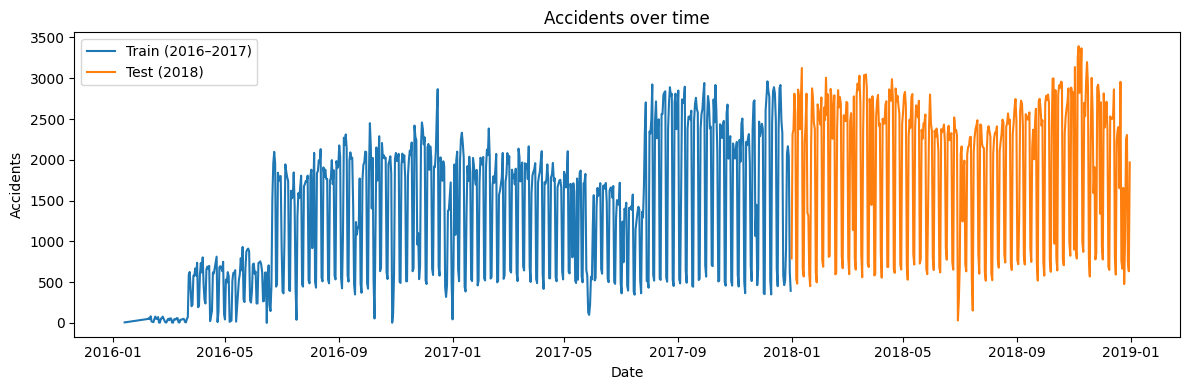

In [148]:
import matplotlib.pyplot as plt

# Convertir columnas 'Date' a tipo fecha en Spark (si no lo has hecho ya)
from pyspark.sql.functions import to_date

df_train = df_countrywise_16_17.withColumn("Date", to_date("Date"))
df_test = df_countrywise_18.withColumn("Date", to_date("Date"))

# Convertir a Pandas para graficar
pdf_train = df_train.select("Date", "Accidents").orderBy("Date").toPandas()
pdf_test = df_test.select("Date", "Accidents").orderBy("Date").toPandas()

# Asegurar que las fechas sean tipo datetime en pandas
pdf_train["Date"] = pd.to_datetime(pdf_train["Date"])
pdf_test["Date"] = pd.to_datetime(pdf_test["Date"])

# Graficar
plt.figure(figsize=(12, 4))
plt.plot(pdf_train["Date"], pdf_train["Accidents"], label="Train (2016–2017)")
plt.plot(pdf_test["Date"], pdf_test["Accidents"], label="Test (2018)")
plt.legend()
plt.title("Accidents over time")
plt.xlabel("Date")
plt.ylabel("Accidents")
plt.tight_layout()
plt.show()